# Kaggle Handwritten Digit Recognizer using Keras



## List of models tried in this notebook : 

The purpose of this notebook was not to get state of the art results but rather to try our a bunch of different models and ideas.

        - Simple Linear Model
        - Single Dense Layer Model
        - Single Dense Layer Model with Dropout
        - Very Basic CNN Model
        - CNN with Data Augmentation 
        - CNN with Data Augmentation and Batch Normalization
        - CNN with Data Augmentation, Batch Normalization and Dropouts
        - Ensemble (really cool!)

## Importing Modules

In [1]:
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D, BatchNormalization, Lambda
from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
np.random.seed(7)

## Loading data

We can use numpy's loadtxt method in order to load the train data. Setting skiprows to 1 allows us to skip the initial header row.

Reference : https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.loadtxt.html

In [3]:
raw_data = np.loadtxt('data/digits/train.csv', skiprows=1, dtype='int', delimiter=',')

In [4]:
raw_data.shape

(42000, 785)

We have 42000 training examples with 785 columns. In this case, the first column is the actual label and the rest 784 columns are the flatenned 28x28 image pixel values.

Let us look at the first five rows of the data.

In [5]:
raw_data[:5]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Let us look at the first few labels

In [6]:
raw_data[0:20,0]

array([1, 0, 1, 4, 0, 0, 7, 3, 5, 3, 8, 9, 1, 3, 3, 1, 2, 0, 7, 5])

Since we want to seperate out our targets, we remove the first column and store it in our target variable

In [7]:
X_train = raw_data[:,1:]
Y_train = raw_data[:,0]

We can use the convinient train_test_split function of sklearn which will help us split the train data in such a way that 20% of that will go for validation

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

In [9]:
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(33600, 784) (33600,) (8400, 784) (8400,)


Now, we need to transform our data back into the 28x28 shape to feed into a Deep Neural Network

In [10]:
X_train = X_train.reshape(X_train.shape[0], 28,28)


In [11]:
X_val = X_val.reshape(X_val.shape[0], 28,28)

In [12]:
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(33600, 28, 28) (33600,) (8400, 28, 28) (8400,)


#### Let us look at a few of the training examples

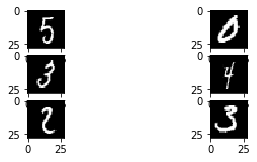

In [22]:
for i in range(0,6):
    plt.subplot(5,2,i+1)
    plt.imshow(X_train[i], cmap='gray')

Now, we need to order the data into the channel ordering which is expected by tenserflow, since we are using Keras with a tensorflow backend

Tensorflow follows a CHANNEL_LAST format. (Note channel refers to the color channel, here, it is 1 since we have a grayscale image, it will be 3 for an RGB image)

In [23]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

In [24]:
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(33600, 28, 28, 1) (33600,) (8400, 28, 28, 1) (8400,)


The labels that we have are int he integer format. We would need to convert them to a categorical format, also called one-hot-encoding, since the loss function that we will be using is 'categorical_crossentropy'

Reference : https://keras.io/utils/#to_categorical

In [25]:
Y_train = to_categorical(Y_train, num_classes=10)
Y_val = to_categorical(Y_val, num_classes=10)

## A Very Simple Linear Model

Let us first try to fit a very simple linear model to the data which just has a single Dense softmax layer.

NOTE : We are using the BatchNormalization layer as the first layer since we want to normalize the image data before feeding it into the network

Reference : https://keras.io/layers/normalization/#batchnormalization

In [30]:
def linear_model():
    model = Sequential()
    model.add(BatchNormalization(axis=1, input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(10, activation = 'softmax'))
    model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

In [31]:
linear_model = linear_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 28, 28, 1)         112       
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,962
Trainable params: 7,906
Non-trainable params: 56
_________________________________________________________________


Since the data is too big to fit into memory directly, we use a Keras utility called ImageDataGenerator which generates batches of tensor image data with (optional) real-time data augmentation. The data will be looped over (in batches) indefinitely.

Reference : https://keras.io/preprocessing/image/#imagedatagenerator

In [32]:
batch_size = 256
gen = image.ImageDataGenerator()
train_batches = gen.flow(X_train, Y_train, batch_size=batch_size)
valid_batches = gen.flow(X_val, Y_val, batch_size=batch_size)

Since the data is generated batch by batch by a generator, we use another Keras utility called fit_generator which fits the model on data generated batch-by-batch by a Python generator.

The generator is run in parallel to the model, for efficiency. For instance, this allows you to do (optional) real-time data augmentation on images on CPU in parallel to training your model on GPU.

Reference : https://keras.io/models/sequential/

In [33]:
steps_per_epoch = int(np.ceil(train_batches.n/batch_size))
validation_steps = int(np.ceil(valid_batches.n/batch_size))
linear_model.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/10
132/132 [==============================] - 3s 24ms/step - loss: 0.8172 - acc: 0.7501 - val_loss: 0.4244 - val_acc: 0.8715
Epoch 2/10
132/132 [==============================] - 1s 7ms/step - loss: 0.3782 - acc: 0.8908 - val_loss: 0.3430 - val_acc: 0.8975
Epoch 3/10
132/132 [==============================] - 1s 7ms/step - loss: 0.3277 - acc: 0.9037 - val_loss: 0.3149 - val_acc: 0.9068
Epoch 4/10
132/132 [==============================] - 1s 7ms/step - loss: 0.3031 - acc: 0.9130 - val_loss: 0.3005 - val_acc: 0.9114
Epoch 5/10
132/132 [==============================] - 1s 7ms/step - loss: 0.2877 - acc: 0.9173 - val_loss: 0.2987 - val_acc: 0.9143
Epoch 6/10
132/132 [==============================] - 1s 7ms/step - loss: 0.2776 - acc: 0.9195 - val_loss: 0.2882 - val_acc: 0.9156
Epoch 7/10
132/132 [==============================] - 1s 7ms/step - loss: 0.2696 - acc: 0.9220 - val_loss: 0.2868 - val_acc: 0.9173
Epoch 8/10
132/132 [==============================] - 1s 7ms/step - loss: 0

As we can see, in just 10 epochs, we are getting validation accuracies of around 91%, which is not bad considering how overtly simple our model iss

## Single dense layer model

Now let us create a model which has a single dense layer in it

In [40]:
def dense_model():
    model = Sequential()
    model.add(BatchNormalization(axis=1, input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(10, activation = 'softmax'))
    model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

In [41]:
dense_model = dense_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 28, 28, 1)         112       
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                10250     
Total params: 814,202
Trainable params: 814,146
Non-trainable params: 56
_________________________________________________________________


In [42]:
dense_model.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/10
132/132 [==============================] - 2s 12ms/step - loss: 0.2881 - acc: 0.9135 - val_loss: 0.1504 - val_acc: 0.9567
Epoch 2/10
132/132 [==============================] - 1s 9ms/step - loss: 0.1011 - acc: 0.9706 - val_loss: 0.1210 - val_acc: 0.9643
Epoch 3/10
132/132 [==============================] - 1s 9ms/step - loss: 0.0593 - acc: 0.9822 - val_loss: 0.1027 - val_acc: 0.9705
Epoch 4/10
132/132 [==============================] - 1s 9ms/step - loss: 0.0380 - acc: 0.9892 - val_loss: 0.0986 - val_acc: 0.9720
Epoch 5/10
132/132 [==============================] - 1s 9ms/step - loss: 0.0225 - acc: 0.9943 - val_loss: 0.1023 - val_acc: 0.9714
Epoch 6/10
132/132 [==============================] - 1s 9ms/step - loss: 0.0144 - acc: 0.9966 - val_loss: 0.0964 - val_acc: 0.9740
Epoch 7/10
132/132 [==============================] - 1s 9ms/step - loss: 0.0106 - acc: 0.9975 - val_loss: 0.0932 - val_acc: 0.9757
Epoch 8/10
132/132 [==============================] - 1s 9ms/step - loss: 0

The above model has a clear case of overfitting since our training accuracy has reached 100% but we only have 97.8% validation accuracy.

## Single dense layer model with dropout

Since our above model was overfitting, we can add Dropout to it in order to add regularization to our deep neural network

In [50]:
def dense_model_dropout():
    model = Sequential()
    model.add(BatchNormalization(axis=1, input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(10, activation = 'softmax'))
    model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

In [51]:
dense_model_drpout = dense_model_dropout()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 28, 28, 1)         112       
_________________________________________________________________
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                10250     
Total params: 814,202
Trainable params: 814,146
Non-trainable params: 56
_________________________________________________________________


In [52]:
dense_model_drpout.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/10
132/132 [==============================] - 2s 13ms/step - loss: 0.4106 - acc: 0.8750 - val_loss: 0.1695 - val_acc: 0.9493
Epoch 2/10
132/132 [==============================] - 1s 9ms/step - loss: 0.1845 - acc: 0.9439 - val_loss: 0.1305 - val_acc: 0.9611
Epoch 3/10
132/132 [==============================] - 1s 10ms/step - loss: 0.1333 - acc: 0.9590 - val_loss: 0.1091 - val_acc: 0.9664
Epoch 4/10
132/132 [==============================] - 1s 10ms/step - loss: 0.1049 - acc: 0.9670 - val_loss: 0.1032 - val_acc: 0.9695
Epoch 5/10
132/132 [==============================] - 1s 9ms/step - loss: 0.0879 - acc: 0.9721 - val_loss: 0.0997 - val_acc: 0.9695
Epoch 6/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0779 - acc: 0.9755 - val_loss: 0.0897 - val_acc: 0.9739
Epoch 7/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0681 - acc: 0.9780 - val_loss: 0.0910 - val_acc: 0.9732
Epoch 8/10
132/132 [==============================] - 1s 10ms/step - lo

As we can seem the validation accuracy is now increasing along with the train accuracy. Thus dropout has helped reduce overfitting in out network. 

Running for a few more epochs ...

In [53]:
dense_model_drpout.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0485 - acc: 0.9839 - val_loss: 0.0901 - val_acc: 0.9767
Epoch 2/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0419 - acc: 0.9858 - val_loss: 0.0895 - val_acc: 0.9777
Epoch 3/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0393 - acc: 0.9859 - val_loss: 0.0853 - val_acc: 0.9796
Epoch 4/10
132/132 [==============================] - 1s 9ms/step - loss: 0.0379 - acc: 0.9874 - val_loss: 0.0896 - val_acc: 0.9773
Epoch 5/10
132/132 [==============================] - 1s 9ms/step - loss: 0.0356 - acc: 0.9878 - val_loss: 0.0899 - val_acc: 0.9780
Epoch 6/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0321 - acc: 0.9895 - val_loss: 0.0954 - val_acc: 0.9768
Epoch 7/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0343 - acc: 0.9886 - val_loss: 0.0894 - val_acc: 0.9782
Epoch 8/10
132/132 [==============================] - 1s 10ms/step - lo

## Very basic CNN model

The previous model with a single dense layer gave us Validation accuracies of almost 98%. Let us now try to fit a very simply CNN model to the data. 

This CNN architecture is heavily inspired by the VGG model

In [67]:
def basic_cnn():
    model = Sequential()
    model.add(BatchNormalization(axis=1, input_shape=(28,28,1)))
    
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Convolution2D(64, (3,3) ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(128, (3,3) ,activation='relu'))
    model.add(Convolution2D(128, (3,3) ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10,activation='softmax'))
    
    model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

In [68]:
basic_cnn_model = basic_cnn()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_11 (Batc (None, 28, 28, 1)         112       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 128)         0         
__________

In [69]:
basic_cnn_model.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 5, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/5
132/132 [==============================] - 12s 88ms/step - loss: 0.4877 - acc: 0.8373 - val_loss: 0.1802 - val_acc: 0.9475
Epoch 2/5
132/132 [==============================] - 11s 82ms/step - loss: 0.1264 - acc: 0.9610 - val_loss: 0.1199 - val_acc: 0.9620
Epoch 3/5
132/132 [==============================] - 11s 81ms/step - loss: 0.0919 - acc: 0.9716 - val_loss: 0.0759 - val_acc: 0.9756
Epoch 4/5
132/132 [==============================] - 11s 81ms/step - loss: 0.0721 - acc: 0.9779 - val_loss: 0.0684 - val_acc: 0.9806
Epoch 5/5
132/132 [==============================] - 11s 82ms/step - loss: 0.0594 - acc: 0.9816 - val_loss: 0.0767 - val_acc: 0.9755


Lets decrease the learning rate and run for a few more epochs ...

In [70]:
basic_cnn_model.optimizer.lr = 0.001
basic_cnn_model.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/10
132/132 [==============================] - 11s 85ms/step - loss: 0.0551 - acc: 0.9821 - val_loss: 0.0540 - val_acc: 0.9844
Epoch 2/10
132/132 [==============================] - 11s 82ms/step - loss: 0.0557 - acc: 0.9823 - val_loss: 0.0550 - val_acc: 0.9843
Epoch 3/10
132/132 [==============================] - 11s 82ms/step - loss: 0.0519 - acc: 0.9848 - val_loss: 0.0601 - val_acc: 0.9832
Epoch 4/10
132/132 [==============================] - 11s 81ms/step - loss: 0.0444 - acc: 0.9859 - val_loss: 0.0529 - val_acc: 0.9838
Epoch 5/10
132/132 [==============================] - 11s 81ms/step - loss: 0.0429 - acc: 0.9869 - val_loss: 0.0507 - val_acc: 0.9848
Epoch 6/10
132/132 [==============================] - 11s 81ms/step - loss: 0.0399 - acc: 0.9876 - val_loss: 0.0560 - val_acc: 0.9838
Epoch 7/10
132/132 [==============================] - 11s 81ms/step - loss: 0.0394 - acc: 0.9876 - val_loss: 0.0486 - val_acc: 0.9858
Epoch 8/10
132/132 [==============================] - 11s 81ms

A few more epochs ...

In [71]:
basic_cnn_model.optimizer.lr = 0.001
basic_cnn_model.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0353 - acc: 0.9893 - val_loss: 0.0432 - val_acc: 0.9885
Epoch 2/10
132/132 [==============================] - 11s 81ms/step - loss: 0.0374 - acc: 0.9886 - val_loss: 0.0461 - val_acc: 0.9865
Epoch 3/10
132/132 [==============================] - 11s 82ms/step - loss: 0.0346 - acc: 0.9886 - val_loss: 0.0397 - val_acc: 0.9880
Epoch 4/10
132/132 [==============================] - 11s 82ms/step - loss: 0.0303 - acc: 0.9908 - val_loss: 0.0574 - val_acc: 0.9839
Epoch 5/10
132/132 [==============================] - 11s 81ms/step - loss: 0.0330 - acc: 0.9896 - val_loss: 0.0517 - val_acc: 0.9857
Epoch 6/10
132/132 [==============================] - 11s 81ms/step - loss: 0.0327 - acc: 0.9902 - val_loss: 0.0490 - val_acc: 0.9861
Epoch 7/10
132/132 [==============================] - 11s 84ms/step - loss: 0.0286 - acc: 0.9910 - val_loss: 0.0432 - val_acc: 0.9870
Epoch 8/10
132/132 [==============================] - 12s 90ms

## CNN with Data Augmentation

One cool trick to combat overfitting is to generate artificial data in order to increase the amount of data we have. This can be done easily in Keras with the help of the ImageDataGenerator()

In [72]:
gen = ImageDataGenerator(zoom_range=0.15, height_shift_range=0.15, width_shift_range=0.15, rotation_range=15)

In [73]:
train_batches = gen.flow(X_train, Y_train, batch_size=batch_size)
valid_batches = gen.flow(X_val, Y_val, batch_size=batch_size)
basic_cnn_aug = basic_cnn()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_12 (Batc (None, 28, 28, 1)         112       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 128)         0         
__________

In [74]:
basic_cnn_aug.optimizer.lr = 0.01
basic_cnn_aug.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/10
132/132 [==============================] - 13s 95ms/step - loss: 1.8973 - acc: 0.3383 - val_loss: 0.6119 - val_acc: 0.7968
Epoch 2/10
132/132 [==============================] - 11s 87ms/step - loss: 0.4237 - acc: 0.8617 - val_loss: 0.3591 - val_acc: 0.8870
Epoch 3/10
132/132 [==============================] - 11s 81ms/step - loss: 0.2851 - acc: 0.9100 - val_loss: 0.2842 - val_acc: 0.9120
Epoch 4/10
132/132 [==============================] - 11s 80ms/step - loss: 0.2410 - acc: 0.9237 - val_loss: 0.2426 - val_acc: 0.9223
Epoch 5/10
132/132 [==============================] - 11s 81ms/step - loss: 0.2146 - acc: 0.9328 - val_loss: 0.1972 - val_acc: 0.9376
Epoch 6/10
132/132 [==============================] - 11s 83ms/step - loss: 0.1970 - acc: 0.9393 - val_loss: 0.1960 - val_acc: 0.9420
Epoch 7/10
132/132 [==============================] - 11s 81ms/step - loss: 0.1826 - acc: 0.9439 - val_loss: 0.2032 - val_acc: 0.9377
Epoch 8/10
132/132 [==============================] - 11s 80ms

Running for a few more epochs ...

In [75]:
basic_cnn_aug.optimizer.lr = 0.01
basic_cnn_aug.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 12, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/12
132/132 [==============================] - 11s 83ms/step - loss: 0.1682 - acc: 0.9482 - val_loss: 0.1580 - val_acc: 0.9519
Epoch 2/12
132/132 [==============================] - 11s 82ms/step - loss: 0.1580 - acc: 0.9520 - val_loss: 0.1501 - val_acc: 0.9551
Epoch 3/12
132/132 [==============================] - 11s 80ms/step - loss: 0.1557 - acc: 0.9531 - val_loss: 0.1460 - val_acc: 0.9560
Epoch 4/12
132/132 [==============================] - 11s 82ms/step - loss: 0.1462 - acc: 0.9550 - val_loss: 0.1910 - val_acc: 0.9419
Epoch 5/12
132/132 [==============================] - 11s 82ms/step - loss: 0.1491 - acc: 0.9551 - val_loss: 0.1551 - val_acc: 0.9562
Epoch 6/12
132/132 [==============================] - 11s 81ms/step - loss: 0.1508 - acc: 0.9542 - val_loss: 0.1577 - val_acc: 0.9554
Epoch 7/12
132/132 [==============================] - 11s 81ms/step - loss: 0.1490 - acc: 0.9545 - val_loss: 0.1759 - val_acc: 0.9475
Epoch 8/12
132/132 [==============================] - 11s 83ms

In [78]:
basic_cnn_aug.optimizer.lr = 0.001
basic_cnn_aug.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 12, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/12
132/132 [==============================] - 11s 84ms/step - loss: 0.1240 - acc: 0.9627 - val_loss: 0.1346 - val_acc: 0.9611
Epoch 2/12
132/132 [==============================] - 11s 85ms/step - loss: 0.1304 - acc: 0.9606 - val_loss: 0.1983 - val_acc: 0.9399
Epoch 3/12
132/132 [==============================] - 11s 87ms/step - loss: 0.1401 - acc: 0.9592 - val_loss: 0.1445 - val_acc: 0.9582
Epoch 4/12
132/132 [==============================] - 12s 88ms/step - loss: 0.1345 - acc: 0.9598 - val_loss: 0.1500 - val_acc: 0.9576
Epoch 5/12
132/132 [==============================] - 11s 85ms/step - loss: 0.1239 - acc: 0.9624 - val_loss: 0.1352 - val_acc: 0.9586
Epoch 6/12
132/132 [==============================] - 13s 98ms/step - loss: 0.1328 - acc: 0.9607 - val_loss: 0.1656 - val_acc: 0.9557
Epoch 7/12
132/132 [==============================] - 14s 109ms/step - loss: 0.1327 - acc: 0.9610 - val_loss: 0.1420 - val_acc: 0.9585
Epoch 8/12
132/132 [==============================] - 14s 108

## CNN with Data Augmentation and Batch Normalization

One of the most important tasks in Deep Neural Networks is to perform batch_normalizations across the layers which applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. This prevents some activations from scaling up or down too much and also helps speed up training.

In [79]:
def cnn_with_augmentaion_bn():
    model = Sequential()
    model.add(BatchNormalization(axis=1, input_shape=(28,28,1)))
    
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Convolution2D(64, (3,3) ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(128, (3,3) ,activation='relu'))
    model.add(Convolution2D(128, (3,3) ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(10,activation='softmax'))
    
    model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

In [80]:
cnn_augmented_bn = cnn_with_augmentaion_bn()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_13 (Batc (None, 28, 28, 1)         112       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 128)         0         
__________

In [81]:
cnn_augmented_bn.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/10
132/132 [==============================] - 12s 91ms/step - loss: 0.3481 - acc: 0.8922 - val_loss: 0.8443 - val_acc: 0.7529
Epoch 2/10
132/132 [==============================] - 11s 82ms/step - loss: 0.1141 - acc: 0.9645 - val_loss: 0.3491 - val_acc: 0.8954
Epoch 3/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0864 - acc: 0.9736 - val_loss: 0.1189 - val_acc: 0.9618
Epoch 4/10
132/132 [==============================] - 11s 85ms/step - loss: 0.0713 - acc: 0.9780 - val_loss: 0.1210 - val_acc: 0.9649
Epoch 5/10
132/132 [==============================] - 11s 82ms/step - loss: 0.0600 - acc: 0.9813 - val_loss: 0.1049 - val_acc: 0.9680
Epoch 6/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0638 - acc: 0.9799 - val_loss: 0.0851 - val_acc: 0.9740
Epoch 7/10
132/132 [==============================] - 11s 82ms/step - loss: 0.0527 - acc: 0.9836 - val_loss: 0.0777 - val_acc: 0.9760
Epoch 8/10
132/132 [==============================] - 11s 83ms

As we can seem the model with batch normalization is taking fewer epochs to reach higher accuracies than the one without batch normalization.

Lets run this model for a few more epochs ...

In [83]:
cnn_augmented_bn.optimizer.lr = 0.001
cnn_augmented_bn.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 5, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/5
132/132 [==============================] - 11s 86ms/step - loss: 0.0344 - acc: 0.9887 - val_loss: 0.0505 - val_acc: 0.9864
Epoch 2/5
132/132 [==============================] - 11s 85ms/step - loss: 0.0362 - acc: 0.9879 - val_loss: 0.0574 - val_acc: 0.9851
Epoch 3/5
132/132 [==============================] - 11s 84ms/step - loss: 0.0343 - acc: 0.9892 - val_loss: 0.0578 - val_acc: 0.9844
Epoch 4/5
132/132 [==============================] - 11s 83ms/step - loss: 0.0335 - acc: 0.9891 - val_loss: 0.0470 - val_acc: 0.9873
Epoch 5/5
132/132 [==============================] - 11s 83ms/step - loss: 0.0321 - acc: 0.9893 - val_loss: 0.0532 - val_acc: 0.9844


## CNN With Data Augmentation, Batch Normalization and Dropout

In [85]:
def cnn_with_augmentaion_bn_dropout():
    model = Sequential()
    model.add(BatchNormalization(axis=1, input_shape=(28,28,1)))
    
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Convolution2D(64, (3,3) ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(128, (3,3) ,activation='relu'))
    model.add(Convolution2D(128, (3,3) ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    model.add(Dense(10,activation='softmax'))
    
    model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

In [86]:
full_model_cnn = cnn_with_augmentaion_bn_dropout()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 28, 28, 1)         112       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 128)         0         
__________

In [87]:
full_model_cnn.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/10
132/132 [==============================] - 12s 92ms/step - loss: 0.4660 - acc: 0.8529 - val_loss: 0.6893 - val_acc: 0.8786
Epoch 2/10
132/132 [==============================] - 11s 83ms/step - loss: 0.1305 - acc: 0.9603 - val_loss: 0.1908 - val_acc: 0.9569
Epoch 3/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0998 - acc: 0.9697 - val_loss: 0.1552 - val_acc: 0.9510
Epoch 4/10
132/132 [==============================] - 11s 84ms/step - loss: 0.0813 - acc: 0.9753 - val_loss: 0.0864 - val_acc: 0.9730
Epoch 5/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0740 - acc: 0.9777 - val_loss: 0.0932 - val_acc: 0.9702
Epoch 6/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0622 - acc: 0.9807 - val_loss: 0.0810 - val_acc: 0.9775
Epoch 7/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0564 - acc: 0.9829 - val_loss: 0.0647 - val_acc: 0.9799
Epoch 8/10
132/132 [==============================] - 11s 84ms

Running for a few more epochs ...

In [88]:
full_model_cnn.optimizer.lr = 0.001
full_model_cnn.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)

Epoch 1/10
132/132 [==============================] - 11s 86ms/step - loss: 0.0441 - acc: 0.9859 - val_loss: 0.0469 - val_acc: 0.9863
Epoch 2/10
132/132 [==============================] - 11s 84ms/step - loss: 0.0436 - acc: 0.9863 - val_loss: 0.0567 - val_acc: 0.9838
Epoch 3/10
132/132 [==============================] - 11s 84ms/step - loss: 0.0389 - acc: 0.9876 - val_loss: 0.0474 - val_acc: 0.9854
Epoch 4/10
132/132 [==============================] - 11s 85ms/step - loss: 0.0419 - acc: 0.9872 - val_loss: 0.0523 - val_acc: 0.9856
Epoch 5/10
132/132 [==============================] - 11s 85ms/step - loss: 0.0369 - acc: 0.9886 - val_loss: 0.0437 - val_acc: 0.9876
Epoch 6/10
132/132 [==============================] - 11s 85ms/step - loss: 0.0372 - acc: 0.9879 - val_loss: 0.0479 - val_acc: 0.9860
Epoch 7/10
132/132 [==============================] - 11s 84ms/step - loss: 0.0356 - acc: 0.9893 - val_loss: 0.0471 - val_acc: 0.9861
Epoch 8/10
132/132 [==============================] - 11s 84ms

## Ensemble 

One of the coolest and most handy tricks in machine learning is to create an ensemble of models and then average over their predictions. This gives us a boost to our accuracies of about 0.5%

Let us get an ensemble over the full CNN model that we had just before.

In [89]:
def get_ensemble():
    full_model_cnn = cnn_with_augmentaion_bn_dropout()
    full_model_cnn.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)
    full_model_cnn.optimizer.lr = 0.001
    full_model_cnn.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, \
                                               epochs = 10, validation_data = valid_batches, \
                                               validation_steps= validation_steps)
    return full_model_cnn

In [90]:
ensemble_model = [get_ensemble() for i in range(6)]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_19 (Batc (None, 28, 28, 1)         112       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 4, 4, 128)         0         
__________

Epoch 1/10
132/132 [==============================] - 13s 95ms/step - loss: 0.4648 - acc: 0.8540 - val_loss: 0.5767 - val_acc: 0.9105
Epoch 2/10
132/132 [==============================] - 11s 85ms/step - loss: 0.1360 - acc: 0.9581 - val_loss: 0.1713 - val_acc: 0.9580
Epoch 3/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0952 - acc: 0.9706 - val_loss: 0.0785 - val_acc: 0.9755
Epoch 4/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0776 - acc: 0.9762 - val_loss: 0.0922 - val_acc: 0.9726
Epoch 5/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0725 - acc: 0.9775 - val_loss: 0.0813 - val_acc: 0.9751
Epoch 6/10
132/132 [==============================] - 11s 84ms/step - loss: 0.0680 - acc: 0.9789 - val_loss: 0.0947 - val_acc: 0.9714
Epoch 7/10
132/132 [==============================] - 11s 84ms/step - loss: 0.0591 - acc: 0.9811 - val_loss: 0.0766 - val_acc: 0.9785
Epoch 8/10
132/132 [==============================] - 11s 84ms

Epoch 1/10
132/132 [==============================] - 13s 97ms/step - loss: 0.4382 - acc: 0.8626 - val_loss: 0.6135 - val_acc: 0.8963
Epoch 2/10
132/132 [==============================] - 11s 85ms/step - loss: 0.1297 - acc: 0.9594 - val_loss: 0.2202 - val_acc: 0.9383
Epoch 3/10
132/132 [==============================] - 11s 83ms/step - loss: 0.1018 - acc: 0.9677 - val_loss: 0.0855 - val_acc: 0.9751
Epoch 4/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0801 - acc: 0.9749 - val_loss: 0.0827 - val_acc: 0.9740
Epoch 5/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0662 - acc: 0.9791 - val_loss: 0.0668 - val_acc: 0.9798
Epoch 6/10
132/132 [==============================] - 11s 83ms/step - loss: 0.0636 - acc: 0.9803 - val_loss: 0.0692 - val_acc: 0.9795
Epoch 7/10
132/132 [==============================] - 11s 84ms/step - loss: 0.0599 - acc: 0.9813 - val_loss: 0.0828 - val_acc: 0.9760
Epoch 8/10
132/132 [==============================] - 11s 83ms

In [91]:

for i, model in enumerate(ensemble_model):
    model.save_weights('data/digits/models/' + 'digits_'+str(i)+'.pkl')


In [109]:
X_test = np.loadtxt('data/digits/test.csv', skiprows=1, dtype='int', delimiter=',')


In [110]:
X_test.shape

(28000, 784)

Let us now see how the ensemble model does on our validation set

In [95]:
all_preds_val = np.stack([m.predict(X_val, batch_size=256) for m in ensemble_model])

In [99]:
all_preds_val.shape

(6, 8400, 10)

Lets get the mean over all the models in the ensemble

In [100]:
avg_preds_val = all_preds_val.mean(axis=0)

In [101]:
avg_preds_val.shape

(8400, 10)

In [102]:
avg_preds_val[0:5]

array([[  3.06542074e-06,   9.99973476e-01,   3.05996906e-07,
          3.16588853e-07,   1.05535355e-06,   1.42864096e-07,
          1.83400589e-05,   2.28498425e-06,   6.96512700e-07,
          3.88996028e-07],
       [  4.61973180e-08,   9.99992430e-01,   3.64074495e-08,
          5.03943376e-09,   1.07002130e-07,   4.16276755e-08,
          2.29539111e-07,   6.73313843e-06,   3.16081450e-09,
          3.96366460e-07],
       [  2.18388454e-08,   1.77901242e-07,   1.40553496e-07,
          1.53146840e-09,   9.99996185e-01,   8.03152318e-08,
          1.67182634e-07,   2.37736208e-06,   1.02998833e-07,
          8.19700801e-07],
       [  2.00937808e-04,   9.95867014e-01,   1.37414376e-04,
          1.11548343e-06,   1.56365437e-04,   3.20941072e-05,
          3.24417162e-03,   1.97875910e-04,   1.49906962e-04,
          1.31269335e-05],
       [  2.10252051e-06,   4.04362517e-08,   3.07205710e-07,
          3.06940569e-06,   7.30098151e-08,   2.05543915e-06,
          2.23721672e-05

Our current predictions holds the probabilities of each label in the target. Lets predict the label to be the one with the highest probability.

In [103]:
avg_preds_val = np.argmax(avg_preds_val, axis = 1)

In [104]:
avg_preds_val.shape

(8400,)

In [105]:
from sklearn.metrics import accuracy_score

In [106]:
accuracy_score(avg_preds_val, np.argmax(Y_val, axis =1))

0.99464285714285716

Our accuracy of each model individually on the validation set was around 98.8%. On putting an ensemble of just 6 of those models, our accuracies shot up to around 99.5%.

NOTE : After submitting the predictions of this ensemble on the test set on Kaggle, our score was 99.67%

Let us now create out submission file.

In [112]:
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [113]:
X_test.shape

(28000, 28, 28, 1)

In [130]:
all_preds = np.stack([m.predict(X_test, batch_size=256) for m in ensemble_model])
avg_pred = all_preds.mean(axis=0)
avg_preds_label = np.argmax(avg_pred, axis = 1)
avg_preds_label.shape

(28000,)

In [131]:
ids = np.arange(1,28001)

In [132]:
ids

array([    1,     2,     3, ..., 27998, 27999, 28000])

In [133]:
submission = np.stack([ids, avg_preds_label], axis = 1)

In [134]:
submission

array([[    1,     2],
       [    2,     0],
       [    3,     9],
       ..., 
       [27998,     3],
       [27999,     9],
       [28000,     2]])

In [135]:
submission_file_name = 'data/digits/results/submission.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%d', header='ImageId,Label', comments='')

In [136]:
from IPython.display import FileLink
FileLink('data/digits/results/submission.csv')

/home/kshitijg1992/fastai/courses/deeplearning1/nbs/data/digits/results/submission.csv